
# Module 4 Session 4 - Health outcome modeling 

## Authors: Shivam Sharma

#### Date: May 29, 2024


## Section 1 - Data exploration

In [2]:
rm(list=ls())
set.seed(13)

library("data.table")
library("dplyr")
library("parallel")
library('stringr')
library('ggplot2')
library('forester')
library("IRdisplay")


options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 150)

In [3]:
# Load the files for our cohort.
cohort = as.data.frame(fread("../Data/Session4/ParticipantCohort.tsv"))
dim(cohort)
head(cohort)

a1c = as.data.frame(fread("../Data/Session4/ParticipantA1C.tsv"))
dim(a1c)
head(a1c)

t2d = as.data.frame(fread("../Data/Session4/ParticipantT2DStatus.tsv"))
dim(t2d)
head(t2d)

[1] 50000     4

,ParticipantID,Age,Sex,SIRE
,<int>,<dbl>,<chr>,<chr>
1,72855012,18.50098,F,Black
2,60709423,18.00000,F,Black
3,30963548,21.44716,F,Black
4,76818295,24.45020,F,Black
5,68693481,20.64606,F,Black
6,61809284,23.00696,F,Black


[1] 50000     2

,ParticipantID,A1C
,<int>,<dbl>
1,72855012,5.509368
2,60709423,6.166759
3,30963548,9.520273
4,76818295,3.344276
5,68693481,3.242426
6,61809284,5.525102


[1] 50000     2

,ParticipantID,T2DStatus
,<int>,<int>
1,10001701,0
2,10004576,0
3,10006792,0
4,10007268,0
5,10008364,0
6,10008475,1


In [4]:
# Merge the datasets together.
cohort = merge(cohort, a1c, by = "ParticipantID")
cohort = merge(cohort, t2d, by = "ParticipantID")

#Make SIRE as a categorical variable.
cohort$SIRE = factor(cohort$SIRE, level = c("White", "Black", "Hispanic"))
cohort$T2DStatus = factor(cohort$T2DStatus, level = c(0, 1))

dim(cohort)
head(cohort)

[1] 50000     6

,ParticipantID,Age,Sex,SIRE,A1C,T2DStatus
,<int>,<dbl>,<chr>,<fct>,<dbl>,<fct>
1,10001701,50.73368,M,White,4.538563,0
2,10004576,57.51144,F,Black,6.217039,0
3,10006792,52.70796,F,White,6.623903,0
4,10007268,49.73393,F,Hispanic,8.720656,0
5,10008364,43.61219,F,White,6.616829,0
6,10008475,66.53269,M,Hispanic,7.391317,1


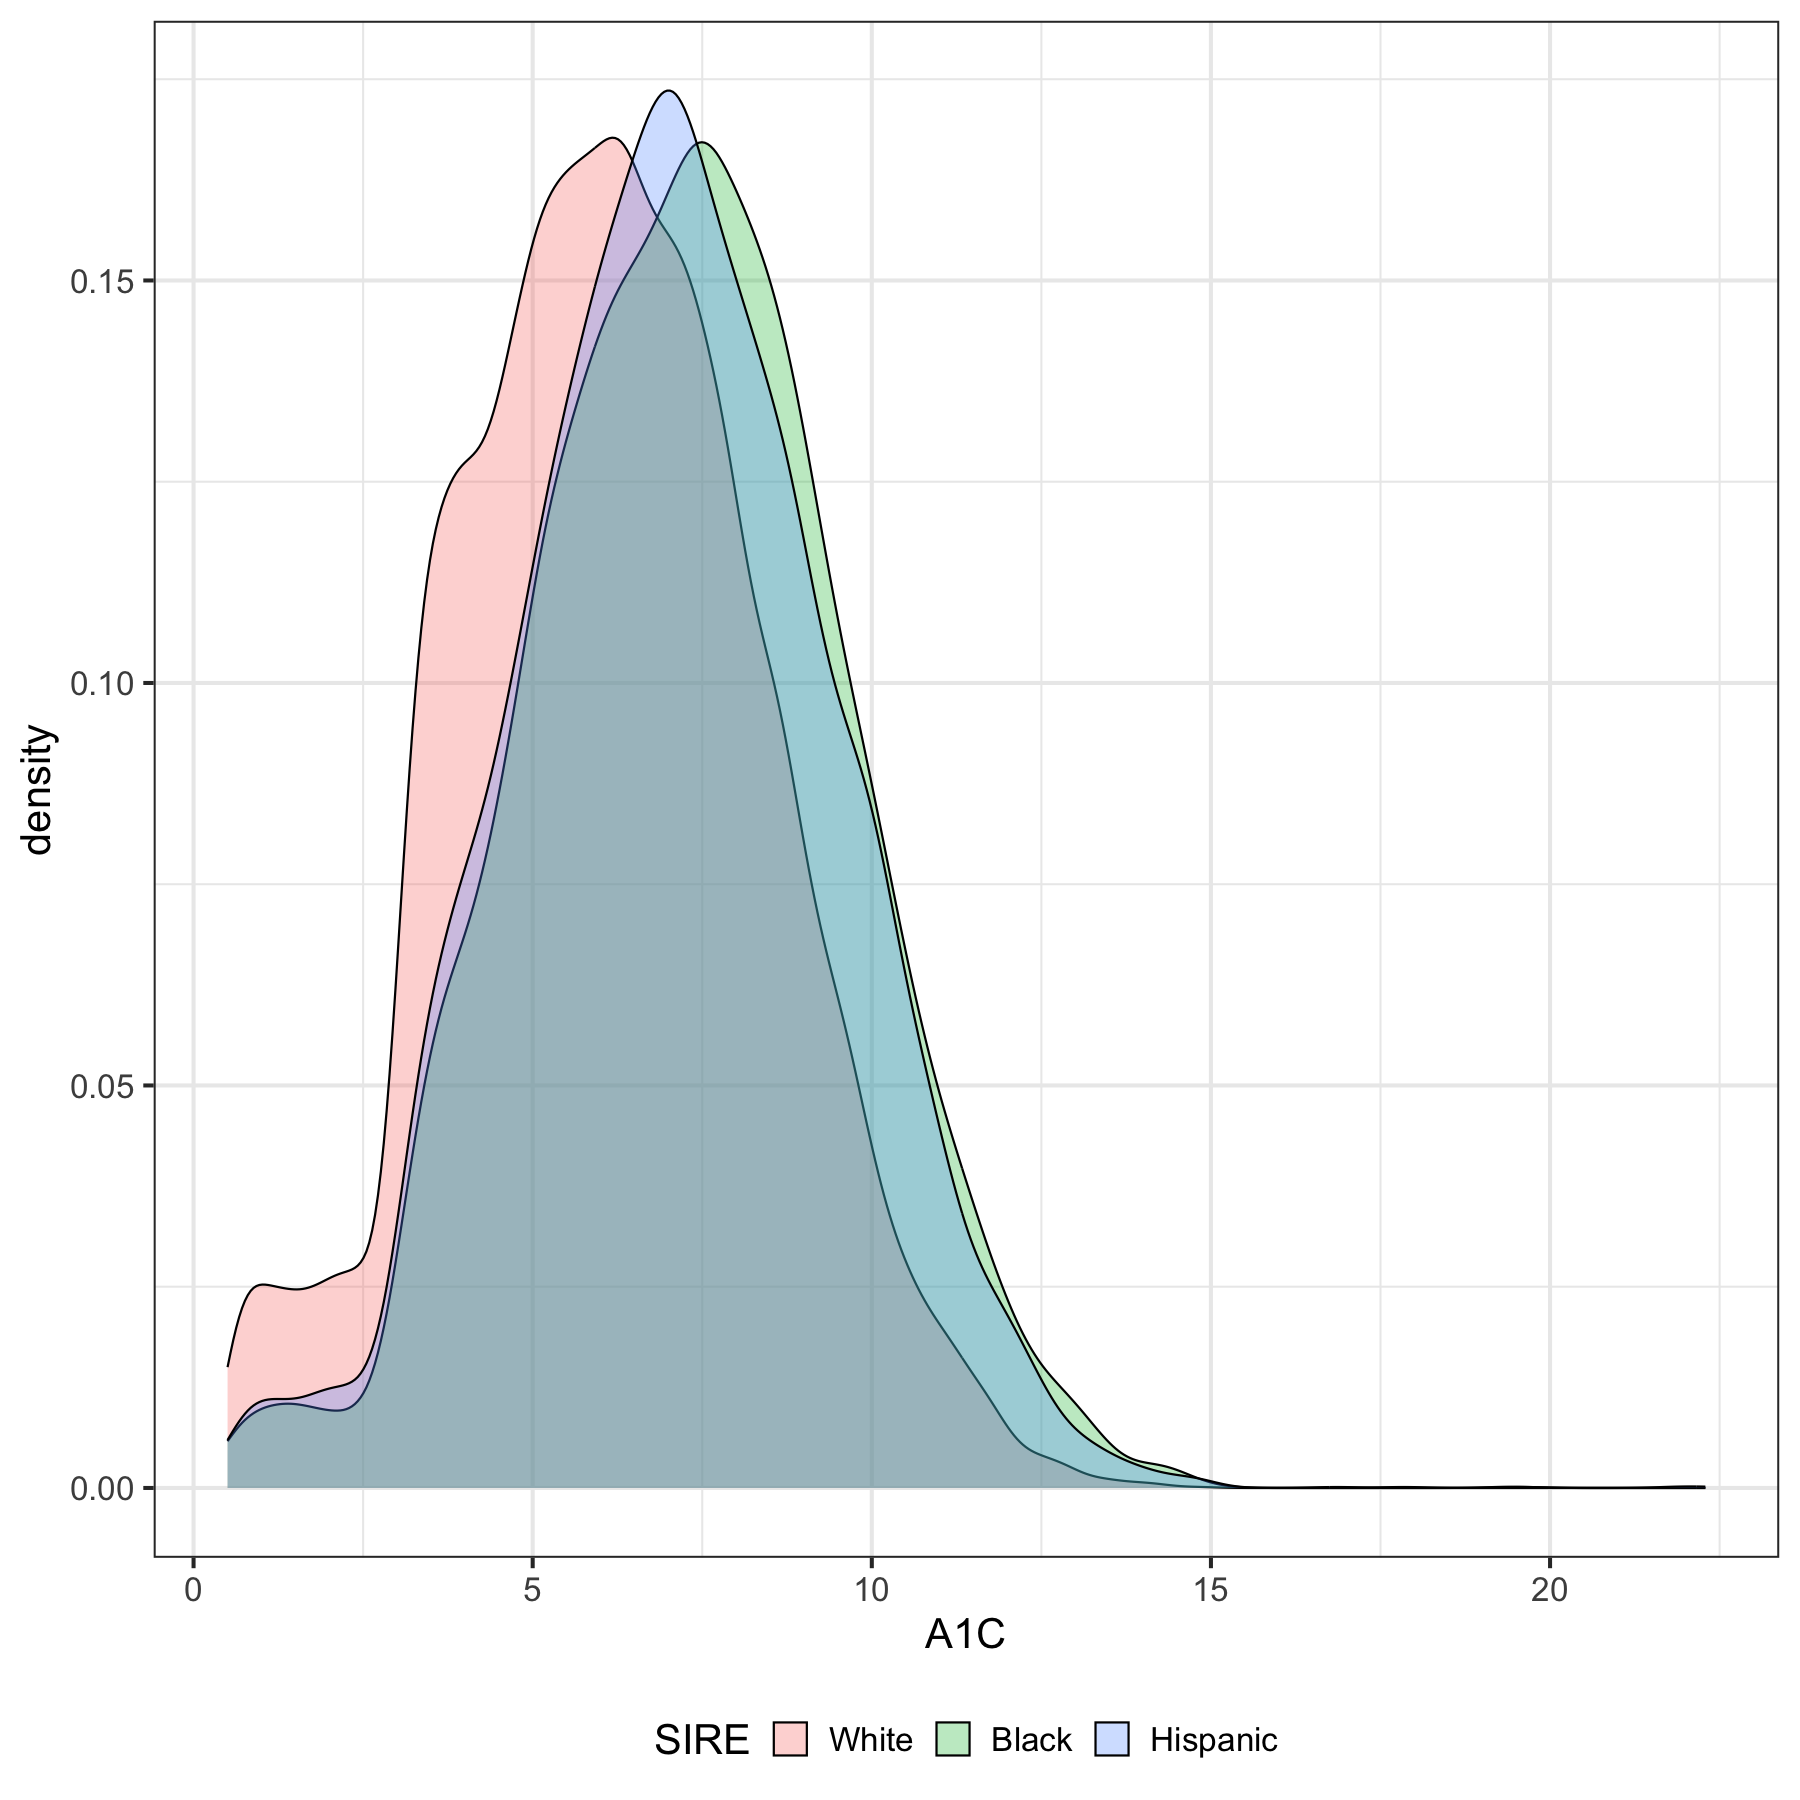

In [5]:
# Visualzie the density of age distribution.
ggplot(cohort, aes(x = A1C, fill = SIRE)) + 
    geom_density(alpha = 0.3) + 
    theme_bw(base_size = 20) + 
    theme(legend.position = "bottom")

In [6]:
# Summarize A1C by SIRE groups.
cohort %>% count(SIRE)

cohort %>%
    group_by(SIRE) %>%
    summarize(
        min = min(A1C),
        max = max(A1C),
        mean = mean(A1C),
        median = median(A1C)
    )

SIRE,n
<fct>,<int>
White,32145
Black,7429
Hispanic,10426


SIRE,min,max,mean,median
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
White,0.5013102,14.91318,6.140689,6.107355
Black,0.5203044,19.44811,7.287397,7.309758
Hispanic,0.5213856,22.28962,7.121485,7.077616


#### Hemoglobin A1C levels and Type 2 Diabetes

For diagnosing purposes, an A1C level of:

    + Less than 5.7% means you don’t have diabetes.
    + 5.7% to 6.4% signals prediabetes.
    + 6.5% or higher usually indicates Type 2 diabetes (or Type 1 diabetes).

## Section 2 - Outlier detection and removal

### 2.1 IQR method

+ IQR - Measures the spread of middle 50% of the data points
+ If an observation is 1.5 times the Q1 and Q3 ranges, it can be considered an outlier (Q1).
+ Non-sensitive to extreme values because mean and sd are not used
+ Doesn't work for skewed data

In [61]:
Q1_A1C <- quantile(cohort$A1C, .25)
Q3_A1C <- quantile(cohort$A1C, .75)
IQR_A1C <- IQR(cohort$A1C)

cohort_filtered <- subset(cohort, cohort$A1C > (Q1_A1C - 1.5*IQR_A1C) & cohort$A1C < (Q3_A1C + 1.5*IQR_A1C))
dim(cohort_filtered)
head(cohort_filtered)

[1] 49827     7

,ParticipantID,Age,Sex,SIRE,A1C,T2DStatus,A1C_Z
,<int>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<dbl>
1,10001701,50.73368,M,White,4.538563,0,0.83398458
2,10004576,57.51144,F,Black,6.217039,0,0.12593748
3,10006792,52.70796,F,White,6.623903,0,0.04569402
4,10007268,49.73393,F,Hispanic,8.720656,0,0.93018664
5,10008364,43.61219,F,White,6.616829,0,0.04271001
6,10008475,66.53269,M,Hispanic,7.391317,1,0.36941910


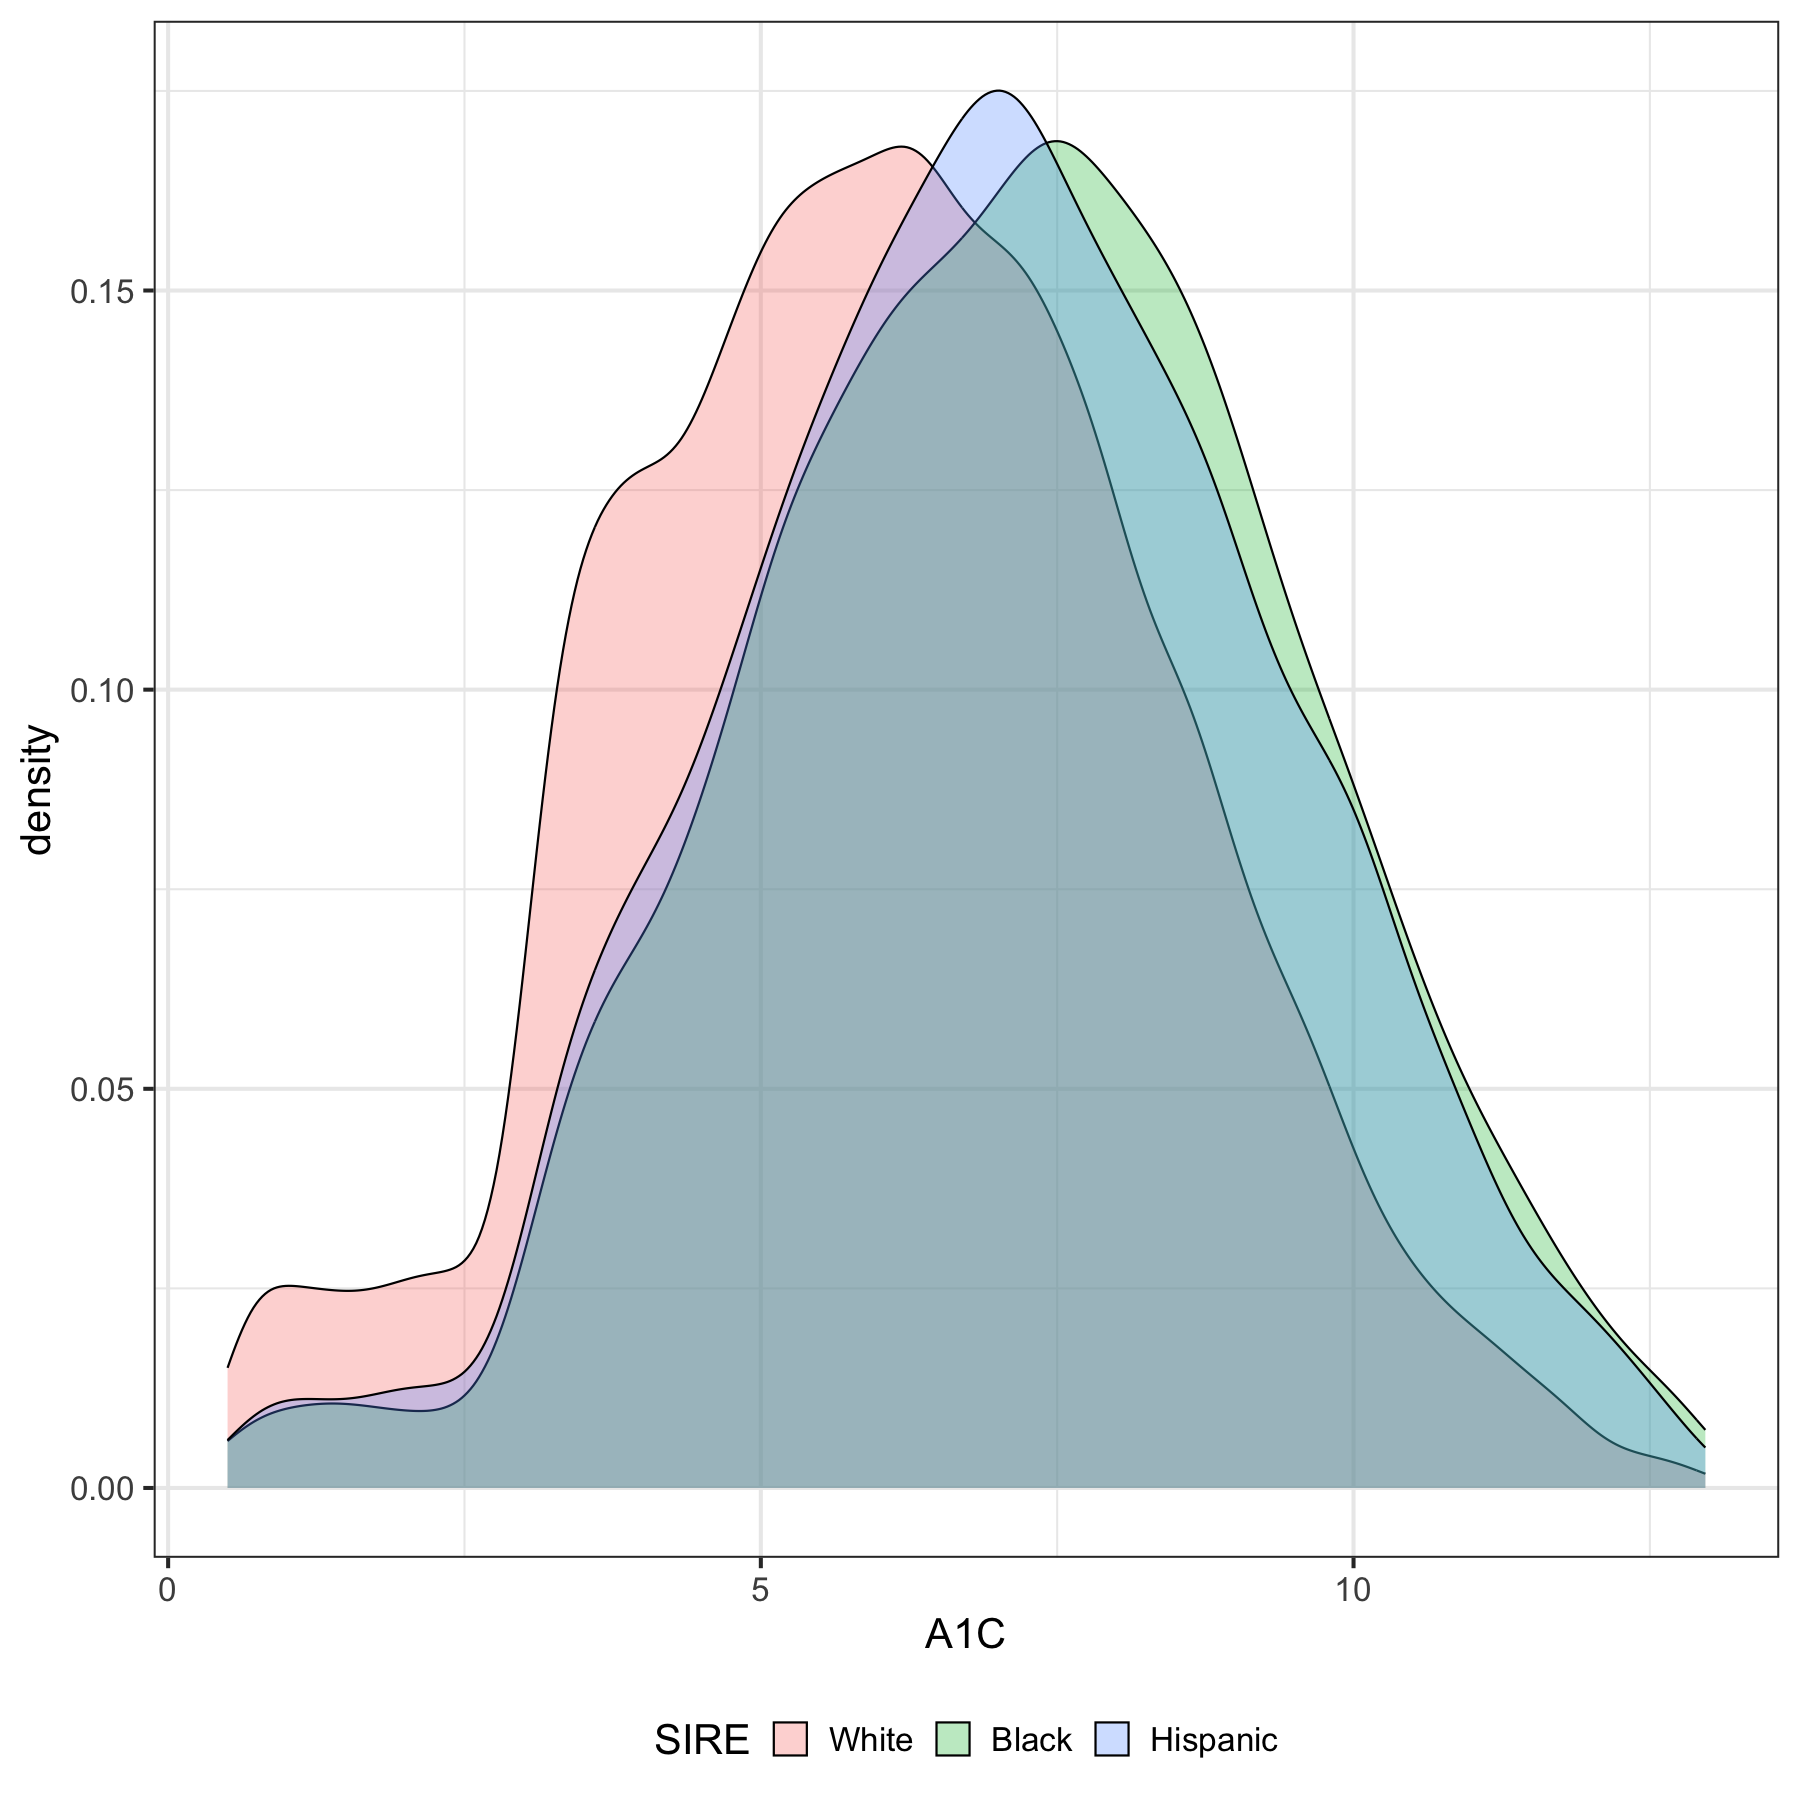

In [48]:
# Visualzie the density of age distribution after IQR outlier removal.
ggplot(cohort_filtered, aes(x = A1C, fill = SIRE)) + 
    geom_density(alpha = 0.3) + 
    theme_bw(base_size = 20) + 
    theme(legend.position = "bottom")

In [52]:
# Summarize A1C after QC
print("Original data:")
cohort %>%
    group_by(SIRE) %>%
    summarize(
        min = min(A1C),
        max = max(A1C),
        mean = mean(A1C),
        median = median(A1C)
    )

print("After IQR outlier removal:")
cohort_filtered %>%
    group_by(SIRE) %>%
    summarize(
        min = min(A1C),
        max = max(A1C),
        mean = mean(A1C),
        median = median(A1C)
    )

[1] "Original data:"


SIRE,min,max,mean,median
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
White,0.5013102,14.91318,6.140689,6.107355
Black,0.5203044,19.44811,7.287397,7.309758
Hispanic,0.5213856,22.28962,7.121485,7.077616


[1] "After IQR outlier removal:"


SIRE,min,max,mean,median
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
White,0.5013102,12.96795,6.129980,6.101842
Black,0.5203044,12.95973,7.236516,7.280871
Hispanic,0.5213856,12.96223,7.074697,7.056950


### 2.2 Using Z-scores


In [56]:
# Calculate Z scores.
cohort$A1C_Z <- abs(cohort$A1C-mean(cohort$A1C))/sd(cohort$A1C)
head(cohort)

cohort_filtered <- cohort[!(cohort$A1C_Z>3), ]
dim(cohort_filtered)
head(cohort_filtered)

,ParticipantID,Age,Sex,SIRE,A1C,T2DStatus,A1C_Z
,<int>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<dbl>
1,10001701,50.73368,M,White,4.538563,0,0.83398458
2,10004576,57.51144,F,Black,6.217039,0,0.12593748
3,10006792,52.70796,F,White,6.623903,0,0.04569402
4,10007268,49.73393,F,Hispanic,8.720656,0,0.93018664
5,10008364,43.61219,F,White,6.616829,0,0.04271001
6,10008475,66.53269,M,Hispanic,7.391317,1,0.36941910


[1] 49922     7

,ParticipantID,Age,Sex,SIRE,A1C,T2DStatus,A1C_Z
,<int>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<dbl>
1,10001701,50.73368,M,White,4.538563,0,0.83398458
2,10004576,57.51144,F,Black,6.217039,0,0.12593748
3,10006792,52.70796,F,White,6.623903,0,0.04569402
4,10007268,49.73393,F,Hispanic,8.720656,0,0.93018664
5,10008364,43.61219,F,White,6.616829,0,0.04271001
6,10008475,66.53269,M,Hispanic,7.391317,1,0.36941910


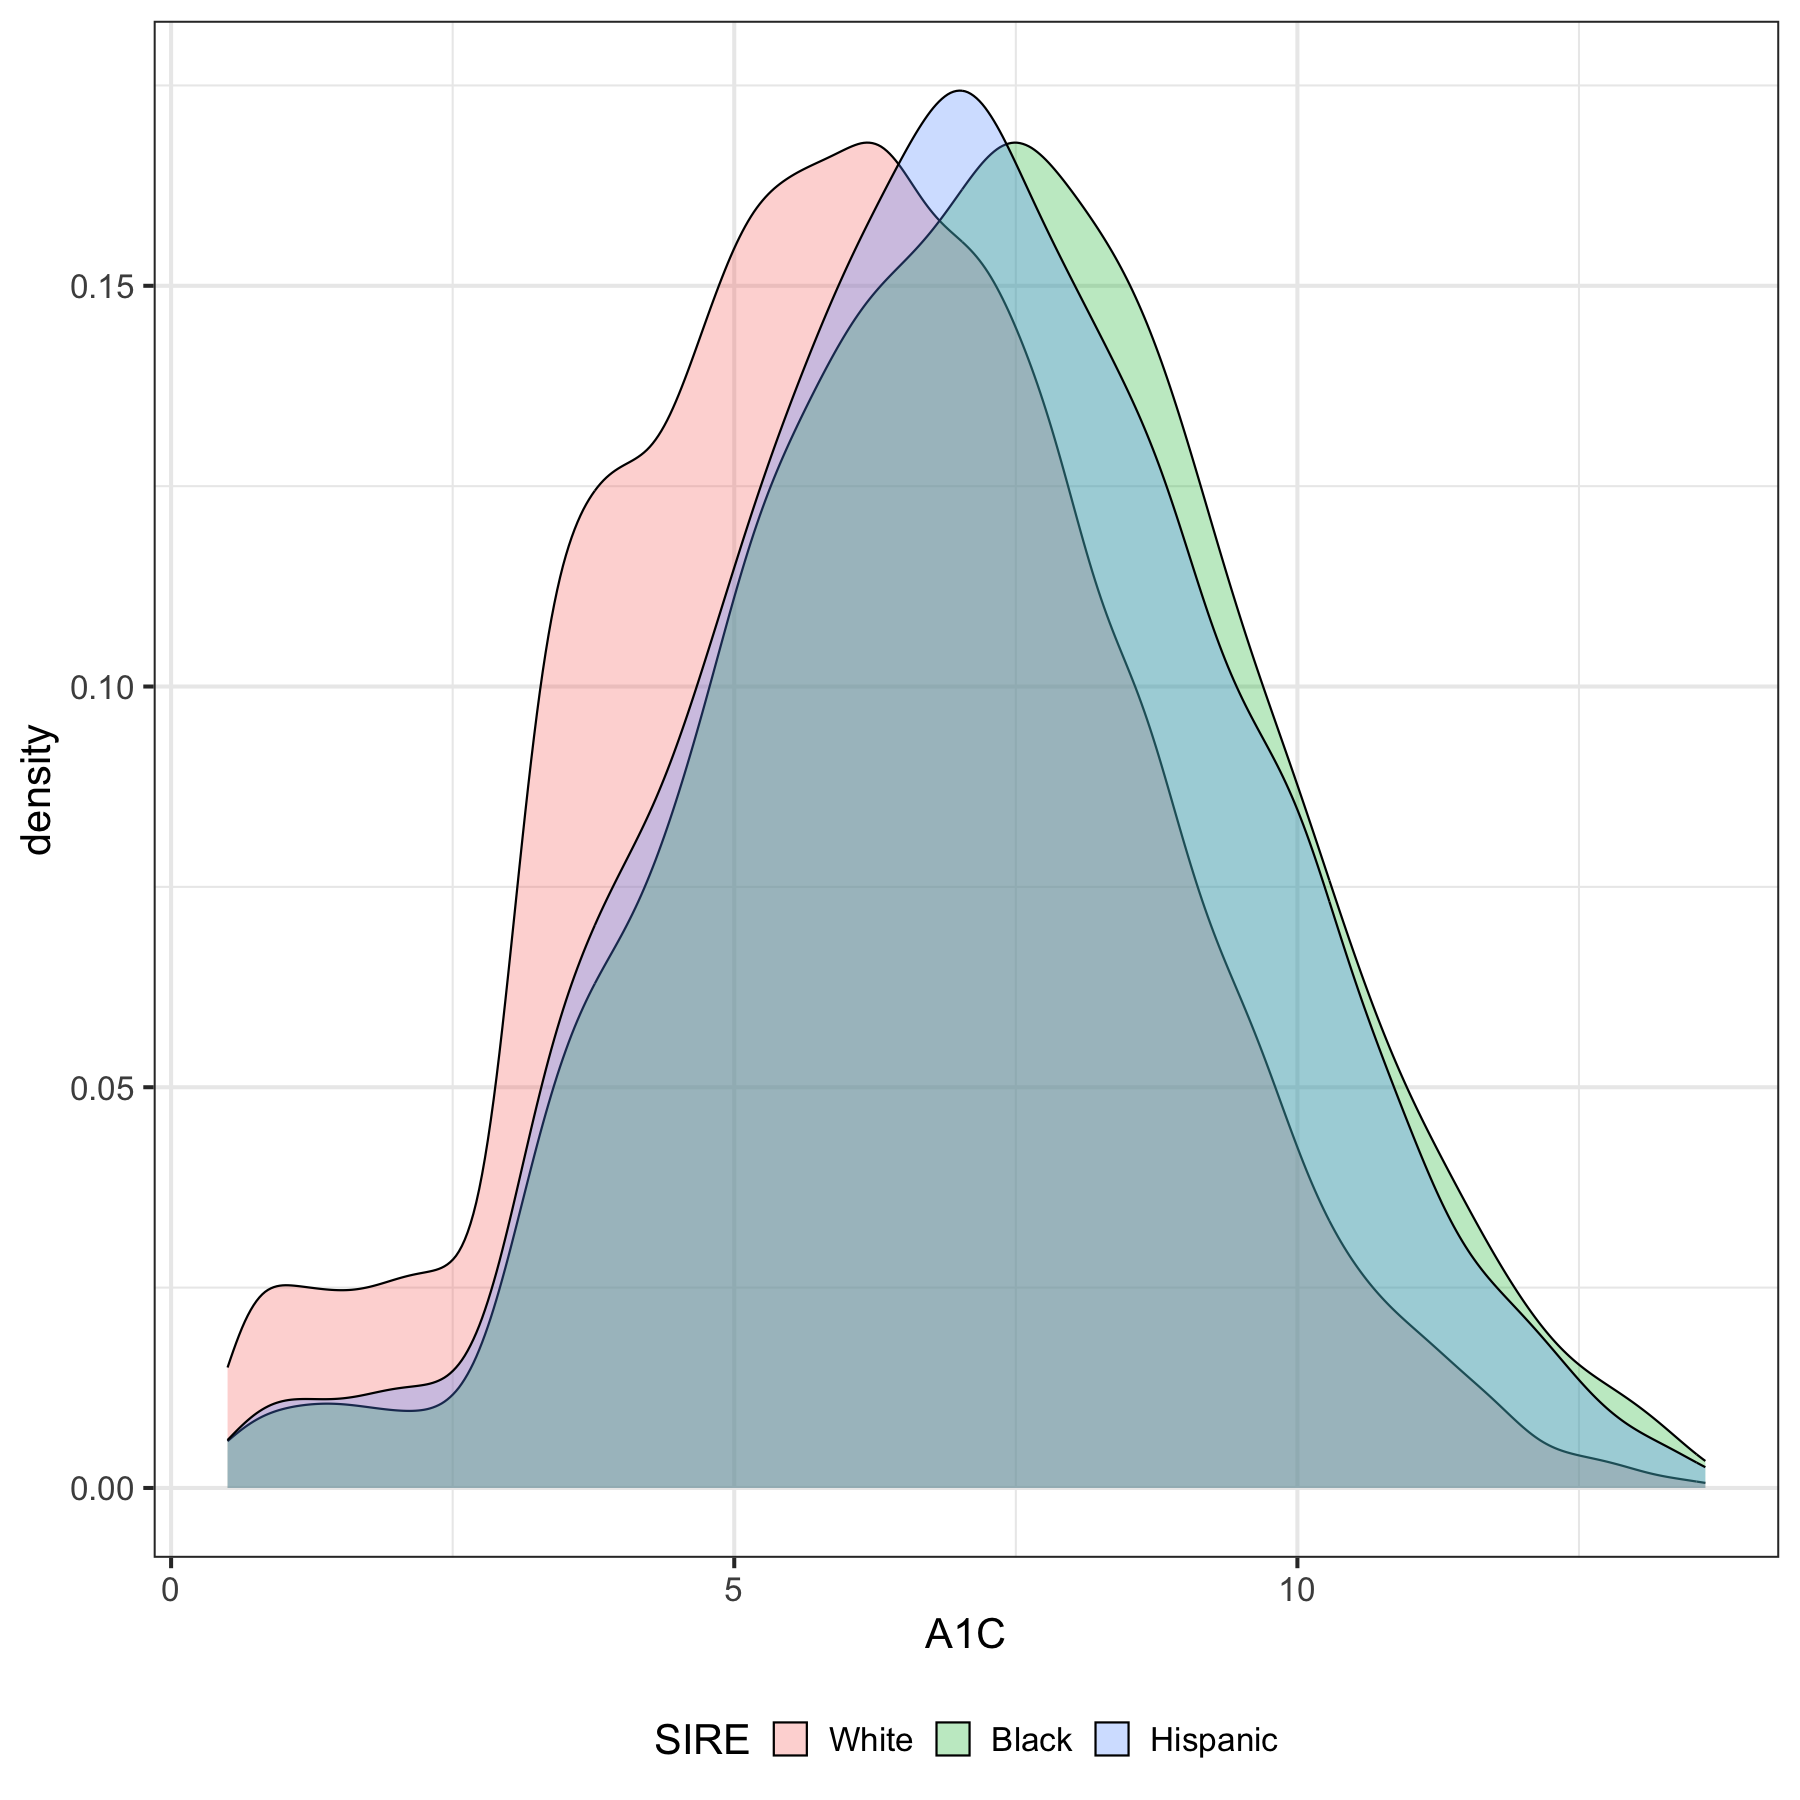

In [57]:
# Visualzie the density of age distribution after IQR outlier removal.
ggplot(cohort_filtered, aes(x = A1C, fill = SIRE)) + 
    geom_density(alpha = 0.3) + 
    theme_bw(base_size = 20) + 
    theme(legend.position = "bottom")

In [59]:
# Summarize A1C after QC
print("Original data:")
cohort %>%
    group_by(SIRE) %>%
    summarize(
        min = min(A1C),
        max = max(A1C),
        mean = mean(A1C),
        median = median(A1C)
    )

print("After Z-score outlier removal:")
cohort_filtered %>%
    group_by(SIRE) %>%
    summarize(
        min = min(A1C),
        max = max(A1C),
        mean = mean(A1C),
        median = median(A1C))
    

[1] "Original data:"


SIRE,min,max,mean,median
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
White,0.5013102,14.91318,6.140689,6.107355
Black,0.5203044,19.44811,7.287397,7.309758
Hispanic,0.5213856,22.28962,7.121485,7.077616


[1] "After Z-score outlier removal:"


SIRE,min,max,mean,median
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
White,0.5013102,13.62195,6.135983,6.105818
Black,0.5203044,13.55003,7.263324,7.300582
Hispanic,0.5213856,13.60363,7.095622,7.069556


### Considerations for large scale EHRs:

+ We have observed unit errors in biomarker data in the All of Us
+ Is the participant an outlier or do they have a few outliers in the record?
+ Nested outlier removal could be implemented based on data distributions

## Section 3 - Disparities between HbA1c levels 

In [62]:
# Create a linear model to test for A1C disparities within the outlier-removed datase.
mod <- lm(A1C ~ SIRE + Sex + Age, data = cohort_filtered)

summary_stats = summary(mod)$coefficients %>% as.data.frame()
summary(mod)


Call:
lm(formula = A1C ~ SIRE + Sex + Age, data = cohort_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.1333 -1.5843 -0.0159  1.5631  7.2999 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.99528    0.06290   79.42   <2e-16 ***
SIREBlack     1.06944    0.02940   36.37   <2e-16 ***
SIREHispanic  0.89096    0.02619   34.02   <2e-16 ***
SexM          0.34396    0.02135   16.11   <2e-16 ***
Age           0.02177    0.00132   16.49   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.27 on 49822 degrees of freedom
Multiple R-squared:  0.05365,	Adjusted R-squared:  0.05357 
F-statistic: 706.1 on 4 and 49822 DF,  p-value: < 2.2e-16


In [7]:
# Create a linear model to test for A1C disparities.
mod <- lm(A1C ~ SIRE + Sex + Age, data = cohort)

summary_stats = summary(mod)$coefficients %>% as.data.frame()
summary(mod)


Call:
lm(formula = A1C ~ SIRE + Sex + Age, data = cohort)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.1987 -1.6037 -0.0311  1.5553 15.1601 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.974102   0.063713   78.07   <2e-16 ***
SIREBlack    1.108227   0.029738   37.27   <2e-16 ***
SIREHispanic 0.925206   0.026505   34.91   <2e-16 ***
SexM         0.352913   0.021629   16.32   <2e-16 ***
Age          0.022384   0.001337   16.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.304 on 49995 degrees of freedom
Multiple R-squared:  0.0558,	Adjusted R-squared:  0.05572 
F-statistic: 738.6 on 4 and 49995 DF,  p-value: < 2.2e-16


---
---

#### Technical considerations
+ SIRE is a categorical variable and results are shown relative to "White" group. This can be changed in the code cell above in the levels argument.
+ Similarly for Sex, the results are show relative to female.
+ Age on the other hand is continuous, so think in terms of "every 1 year increment"


#### Conclusions

+ SIRE = Black; A participant who identifies as Black in our dataset is likely to have 1.1 units higher A1C compared to a participant who identifies as "White" while adjusted for sex and age
+ SIRE = Hispanic; 0.9 units higher
+ Sex = Male; Male participants tend to have 0.35 units higher A1C than females within the SIRE groups and age ranges.
+ Age; For every 1 year added, there is an increment of 0.02 units in A1C levels in our dataset

In [8]:
# Get the confidence intervals for the coefficients.
conf_intervals <- confint(mod) %>% as.data.frame()
names(conf_intervals) = c("Low", "High")

summary_stats = merge(summary_stats, conf_intervals, by='row.names', all=TRUE)
names(summary_stats)[1] = "Variable"

# Round to 2 decimals
summary_stats = summary_stats %>% mutate_if(is.numeric, round, digits = 2) %>% filter(Variable != "(Intercept)")
head(summary_stats)

,Variable,Estimate,Std. Error,t value,Pr(>|t|),Low,High
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Age,0.02,0.00,16.74,0,0.02,0.03
2,SexM,0.35,0.02,16.32,0,0.31,0.40
3,SIREBlack,1.11,0.03,37.27,0,1.05,1.17
4,SIREHispanic,0.93,0.03,34.91,0,0.87,0.98


In [9]:
forest_plot = forester(left_side_data = summary_stats[,c(1,2,5)],
           estimate = summary_stats$Estimate,
           ci_low = summary_stats$Low,
           ci_high = summary_stats$High,
           display = FALSE,
           justify = 0,
           xlim = c(-0.5, 1.5),
           font_family = "courier",
           point_sizes = 1,
                       ggplot_width = 50,
           file_path = here::here("ForestPlot.A1C.png")
        )

New names:
• `Estimate` -> `Estimate...2`
• `Estimate` -> `Estimate...5`


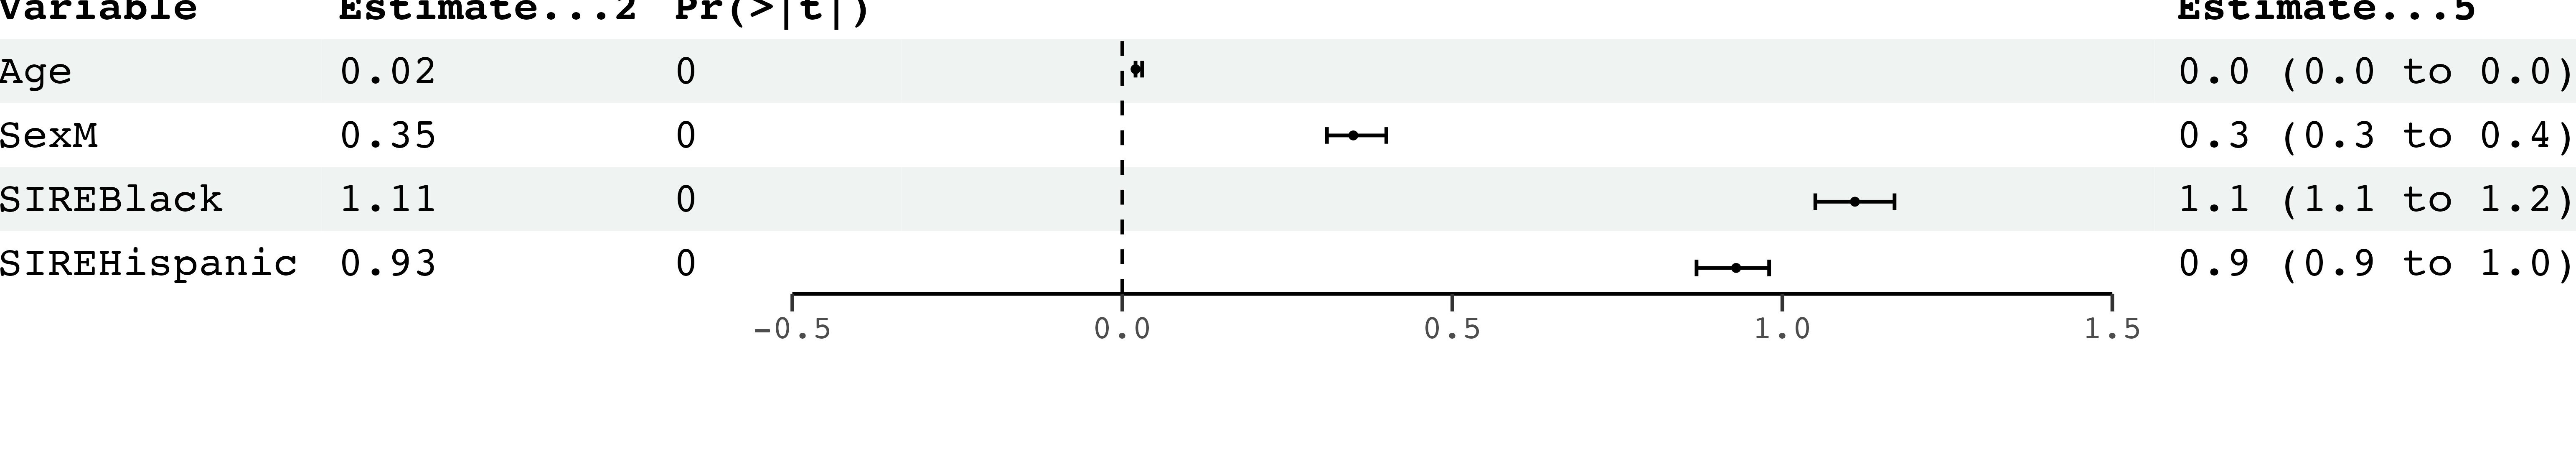

In [10]:
display_png(file = "../ForestPlot.A1C.png")  


## Section 4 - Disparities between type 2 diabetes 

#### For logistic regression, it is important to remember:

 + log((1−p) / p) = β0 + β1X1 + β2X2 + … + βkX
 
 + where p is the probability of the outcome being 1 instead of 0
 
 + Each β represents the change in the log-odds of the response variable being 1 (success) for a one-unit change in the Xi, holding all other predictors constant.

In [17]:
# Create a linear model to test for A1C disparities.
mod <- glm(T2DStatus ~ SIRE + Sex + Age, data = cohort, family = "binomial")

summary_stats = summary(mod)$coefficients %>% as.data.frame()
summary(mod)


Call:
glm(formula = T2DStatus ~ SIRE + Sex + Age, family = "binomial", 
    data = cohort)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1732  -0.6267  -0.4923  -0.4225   2.4392  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.677991   0.079474 -46.279  < 2e-16 ***
SIREBlack     0.826285   0.032998  25.041  < 2e-16 ***
SIREHispanic  0.974378   0.029065  33.524  < 2e-16 ***
SexM          0.173440   0.025851   6.709 1.96e-11 ***
Age           0.032670   0.001608  20.322  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 44327  on 49999  degrees of freedom
Residual deviance: 42199  on 49995  degrees of freedom
AIC: 42209

Number of Fisher Scoring iterations: 4


In [12]:
# Get the confidence intervals for the coefficients.
conf_intervals <- confint(mod) %>% as.data.frame()
names(conf_intervals) = c("Low", "High")

summary_stats = merge(summary_stats, conf_intervals, by='row.names', all=TRUE)
names(summary_stats)[1] = "Variable"

# Round to 2 decimals
summary_stats = summary_stats %>% mutate_if(is.numeric, round, digits = 2) %>% filter(Variable != "(Intercept)")
head(summary_stats)

Waiting for profiling to be done...



,Variable,Estimate,Std. Error,z value,Pr(>|z|),Low,High
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Age,0.03,0.00,20.32,0,0.03,0.04
2,SexM,0.17,0.03,6.71,0,0.12,0.22
3,SIREBlack,0.83,0.03,25.04,0,0.76,0.89
4,SIREHispanic,0.97,0.03,33.52,0,0.92,1.03


In [13]:
forest_plot = forester(left_side_data = summary_stats[,c(1,2,5)],
           estimate = summary_stats$Estimate,
           ci_low = summary_stats$Low,
           ci_high = summary_stats$High,
           display = FALSE,
           justify = 0,
           xlim = c(-0.5, 1.5),
           font_family = "courier",
           point_sizes = 1,
                       ggplot_width = 50,
           file_path = here::here("ForestPlot.T2D.png")
        )

New names:
• `Estimate` -> `Estimate...2`
• `Estimate` -> `Estimate...5`


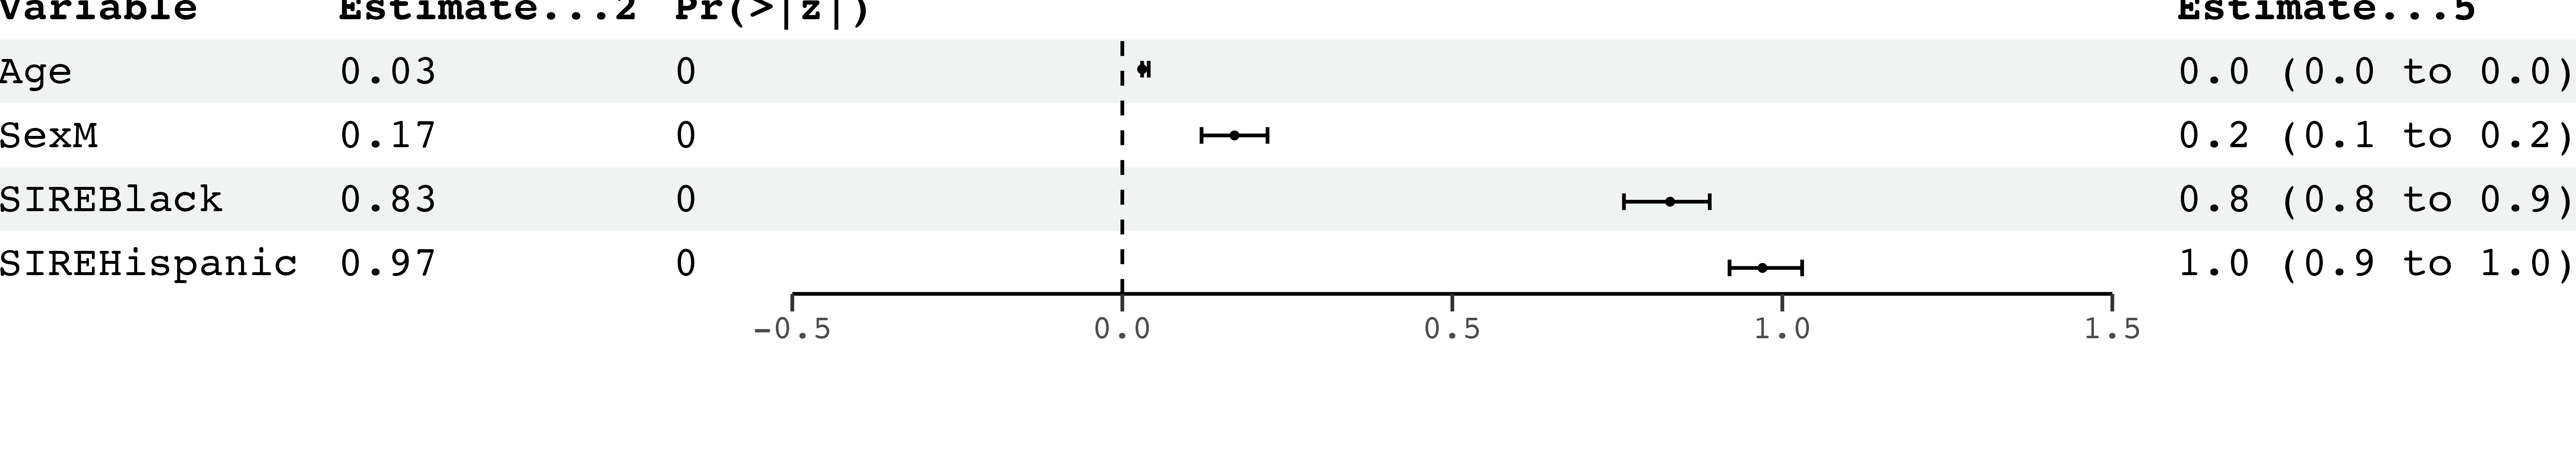

In [14]:
display_png(file = "../ForestPlot.T2D.png")  


### Sometimes it's more effective to visualize odds ratio instead

 + Odds ratio: is a way to express the likelihood of an event occurring vs it not occurring

 + Multiplicative change in the odds of the outcome for a one-unit increase in Xi, holding all other variables constant. 

 + It can be calculated by exponentiating the coefficient βi: OR = exp(βi)

In [42]:
odds_ratio = exp(cbind("OddsRatio" = coef(mod), confint(mod, level = 0.95))) %>% as.data.frame()
names(odds_ratio) = c("OddsRatio", "Low", "High")

odds_ratio$Variable = row.names(odds_ratio)
names(odds_ratio)[4] = "Variable"

# Round to 2 decimals
odds_ratio = odds_ratio %>% mutate_if(is.numeric, round, digits = 2) %>% filter(Variable != "(Intercept)")
head(odds_ratio)

Waiting for profiling to be done...



,OddsRatio,Low,High,Variable
,<dbl>,<dbl>,<dbl>,<chr>
SIREBlack,2.28,2.14,2.44,SIREBlack
SIREHispanic,2.65,2.50,2.80,SIREHispanic
SexM,1.19,1.13,1.25,SexM
Age,1.03,1.03,1.04,Age


---
---

#### Conclusions

+ SIRE = Black; A participant who identifies as Black in our dataset, their odds of having T2D are increased by 2.28; similary for Hispanic by 2.65
+ Sex & Age = Male; For male participants the odds increase by a factor or 1.19 and similarly 1.03 for every one year increase in age

In [43]:
forest_plot = forester(left_side_data = odds_ratio[,c(1,4)],
           estimate = odds_ratio$OddsRatio,
           ci_low = odds_ratio$Low,
           ci_high = odds_ratio$High,
           display = FALSE,
           justify = 0,
           font_family = "courier",
           point_sizes = 1,
                                  xlim = c(0, 3),

           ggplot_width = 50,
           null_line_at = 1,
           file_path = here::here("ForestPlot.T2D.OddsRatio.png")
        )

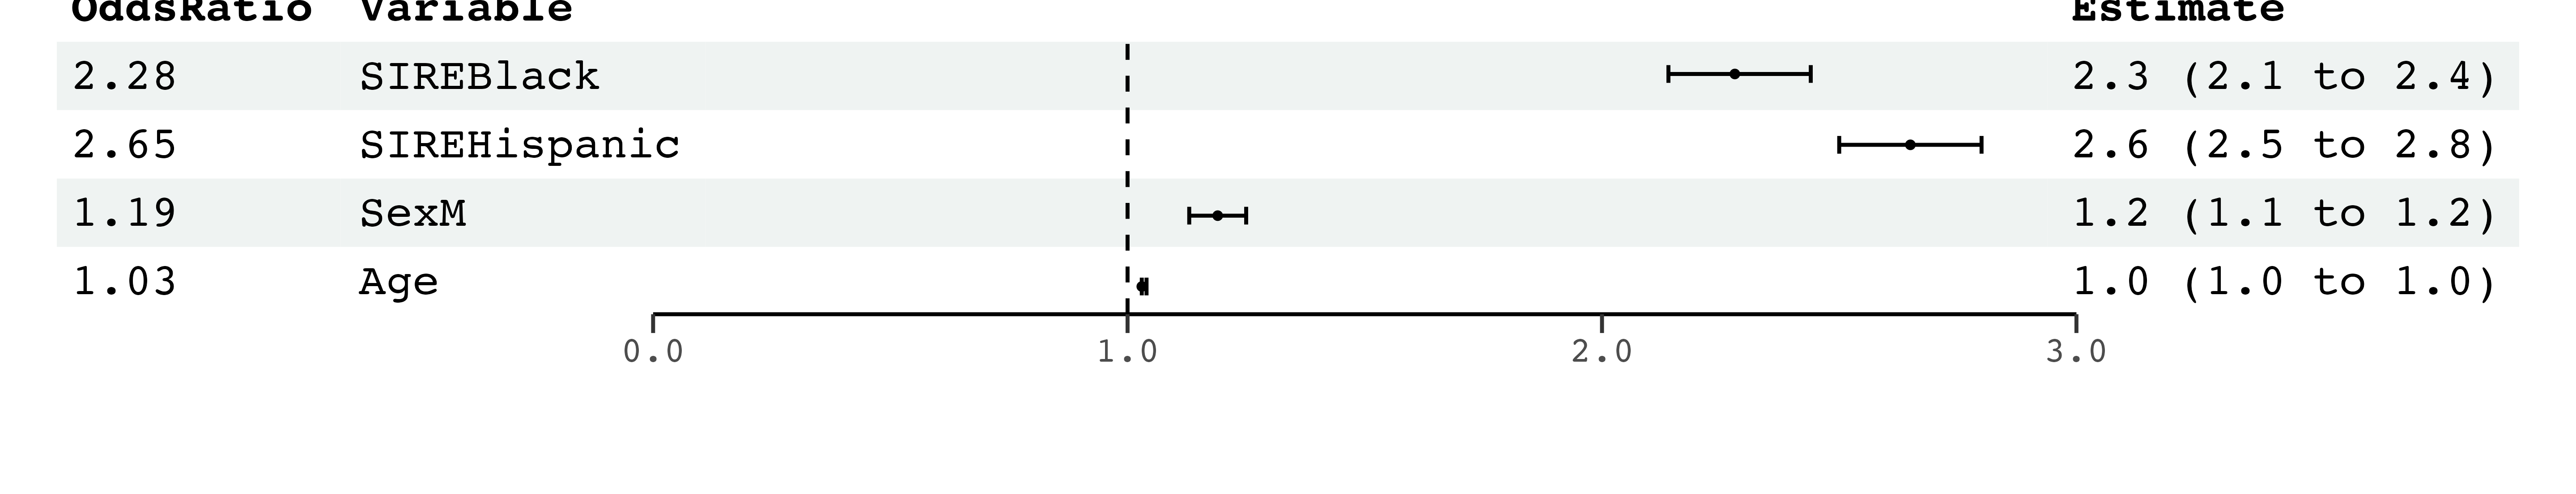

In [44]:
display_png(file = "../ForestPlot.T2D.OddsRatio.png")  
